# Basics of Anomaly Detection

Import libraries

In [1]:
import numpy as np
import pandas as pd
from pyod.utils.data import generate_data
import matplotlib.pyplot as plt

Generate Some Data

In [2]:
contamination = 0.15  #set percentage of outliers
n_train = 500
n_test = 500    #Set the number of training and testing data

n_features = 2   #number of feature in our data, lets keep it simple for now

In [3]:
X_train, y_train, X_test, y_test = generate_data(n_train=n_train, 
                    n_test=n_test, n_features= n_features, contamination=contamination)

C:\Users\aiden\Anaconda3\lib\site-packages\pyod\utils\data.py:190: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)


Lets plot what we have

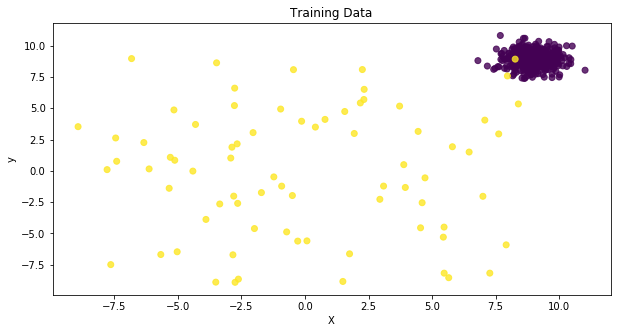

In [4]:
plt.figure(figsize=[10,5])
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, alpha=0.8)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Training Data')
plt.show()

We can see that the outliers are highlighted in yellow, whereas the normal data is purple.

Lets first try K-nearest neighbours to detect the anomalies. It's a non-parametric method that will identify the k closest training examples. Any isoalted data points can be potentially classified as an outlier.

Lets now import and train the model.

In [5]:
from pyod.models.knn import KNN

In [6]:
model_name = 'KNN'
model = KNN()  #Initialise model

In [7]:
model.fit(X_train)
y_predictions = model.predict(X_test)

Now that the model is trained, lets see how our predictions fare.

Predicitons for anomalies are just 0 and 1, so we can just count

In [8]:
unique, counts = np.unique(y_predictions, return_counts=True)

In [9]:
print(unique, counts)

[0 1] [448  52]


In [10]:
y_test_scores = model.decision_function(X_test) #Calculate Anomaly Scores

k-NN model uses the Euclidean Distance to measure the distance between points. An outlier is a point thats distant from neighbours, so the outlier score will be defined by the distance value. 

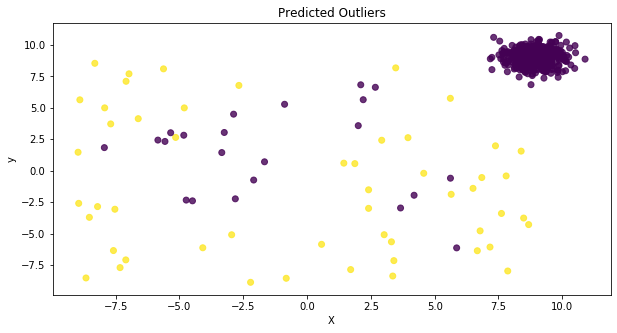

In [11]:
plt.figure(figsize=[10,5])
plt.scatter(X_test[:,0], X_test[:,1], c=y_predictions, alpha=0.8)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Predicted Outliers')
plt.show()

It looks like a lot of the outliers have been classfied as "normal".

Let's explore the Anomaly Scores

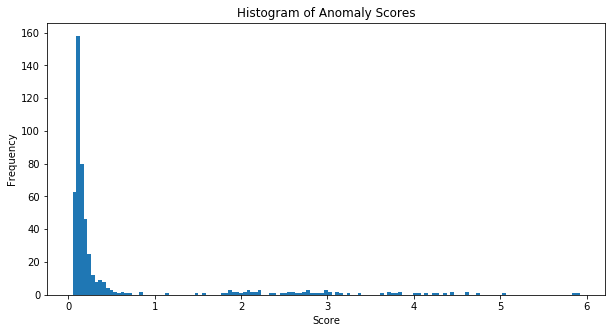

In [12]:
plt.figure(figsize=[10,5])
plt.hist(y_test_scores, bins='auto')
plt.title('Histogram of Anomaly Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

Now let's show the summary statistics of the normal and abnormal clusters.
Because we have generated data, let's jsut label then as "Feature 0" and "Feature 1"

In [13]:
df_test = pd.DataFrame(X_test)
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<1, 0, 1)
df_test['cluster'].value_counts()
df_test.rename(columns={0:'Feature 0', 1:'Feature 1'}, inplace = True)
# Now let's show the summary statistics:

df_test.groupby('cluster').mean()


,Feature 0,Feature 1,score
cluster,,,
0,8.965824,8.981820,0.169163
1,-0.465629,-0.340412,2.954051


It looks like cluster 0 averages higher for both features than cluster 1 and has an anomaly score close to 0, whereas cluster 1, the outliers, have a much greater anomaly score.

Looking at our test data graph above, we can see the model has over-fitted.

Lets try to make a more stable model. We can try aggregating multiple models

We can train multiple models and then aggregate their scores. This will reduce the chance of voerfitting and increase the prediction accuracy

First we will generage 20 k-NN models and collect all the model predictions in one dataset. Each of the 500 observations will ahve 20 predictions.

In [15]:
from pyod.models.combination import aom, moa, average, maximization

In [17]:
from pyod.utils.utility import standardizer

standardise data

In [18]:
X_train_norm, X_test_norm = standardizer(X_train, X_test)

Test a Range of k-neighbours from 10 to 200, there will be 20 models

In [19]:
n_knn = 20

In [30]:
k_list = []

num = 10

while num <201:
    k_list.append(num)
    num += 10

In [31]:
train_scores = np.zeros([X_train.shape[0], n_knn])
test_scores = np.zeros([X_train.shape[0], n_knn])
train_scores.shape

(500, 20)

In [32]:
for i in range(n_knn):
    k = k_list[i]
    model = KNN(n_neighbors=k, method='largest')
    model.fit(X_train_norm)
    
    train_scores[:, i] = model.decision_scores_
    test_scores[:, i] = model.decision_function(X_test_norm) 

In [33]:
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

Now we have generated the scores, lets try a few different ways to aggregate.

Method 1 - Average

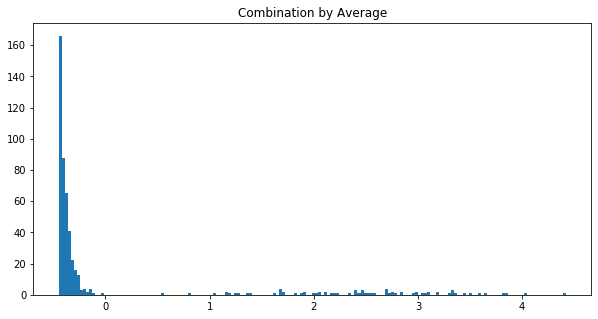

In [35]:
# Combination by average
# The test_scores_norm is 500 x 20. The "average" function will take the average of the 20 columns. The result "y_by_average" is a single column: 
y_by_average = average(test_scores_norm)
plt.figure(figsize=[10,5])
plt.hist(y_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by Average")
plt.show()

In [41]:
test_df = pd.DataFrame(X_test)
test_df['y_by_average_score'] = y_by_average
test_df['y_by_average_cluster'] = np.where(test_df['y_by_average_score']<0, 0, 1)
test_df['y_by_average_cluster'].value_counts()

0    426
1     74
Name: y_by_average_cluster, dtype: int64

In [40]:
test_df.groupby('y_by_average_cluster').mean()

,0,1,y_by_average_score
y_by_average_cluster,,,
0,8.961938,8.985609,-0.387223
1,-0.570708,-0.488203,2.446473


We have identified 74 Anamolous datapoints, where the outlier score is greater than zero.

In [43]:
test_df.rename(columns={0:'Feature 0', 1:'Feature 1'}, inplace = True)
test_df.head()

,Feature 0,Feature 1,y_by_average_score,y_by_average_cluster
0,8.573410,8.552913,-0.424291,0
1,9.180187,9.799576,-0.386967,0
2,9.795576,9.467467,-0.372972,0
3,8.865531,8.401837,-0.432675,0
4,9.020948,8.714417,-0.448208,0


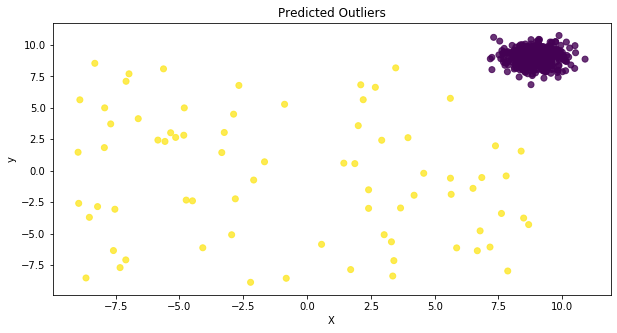

In [45]:
plt.figure(figsize=[10,5])
plt.scatter(test_df['Feature 0'], test_df['Feature 1'], c=test_df['y_by_average_cluster'], alpha=0.8)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Predicted Outliers')
plt.show()

This is definitely looking better than the single kNN we tried earlier.

Lets try method 2 - Using the Maximum of Maximum (MoM)

In [46]:
y_by_maximisation = maximization(test_scores_norm)

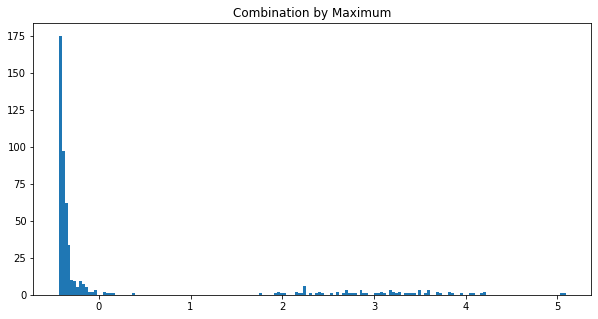

In [47]:
plt.figure(figsize=[10,5])
plt.hist(y_by_maximisation, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by Maximum")
plt.show()

In [67]:
df_test = pd.DataFrame(X_test)
df_test['y_by_maximisation_score'] = y_by_maximisation
df_test['y_by_maximisation_cluster'] = np.where(df_test['y_by_maximisation_score']<0, 0, 1)
df_test['y_by_maximisation_cluster'].value_counts()

0    420
1     80
Name: y_by_maximisation_cluster, dtype: int64

This is showing 80 outliers, up fromt he 74 we identified earlier.

In [68]:
df_test.groupby('y_by_maximisation_cluster').mean()

,0,1,y_by_maximisation_score
y_by_maximisation_cluster,,,
0,8.967011,8.982146,-0.370872
1,0.117609,0.240514,2.807865


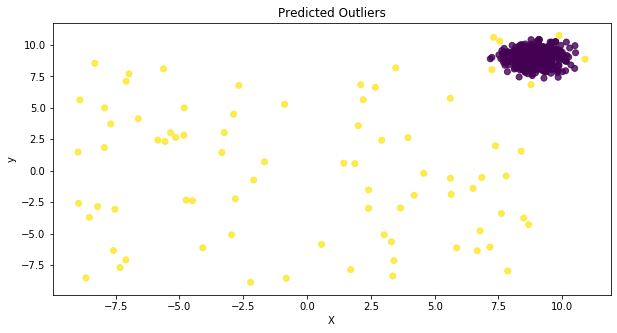

In [69]:
df_test.rename(columns={0:'Feature 0', 1:'Feature 1'}, inplace = True)
plt.figure(figsize=[10,5])
plt.scatter(df_test['Feature 0'], df_test['Feature 1'], c=df_test['y_by_maximisation_cluster'], alpha=0.8)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Predicted Outliers')
plt.show()

we can see that this method is a more sensitive than the previous method.

Now Lets try method 3 - Average of Maximum (AoM)

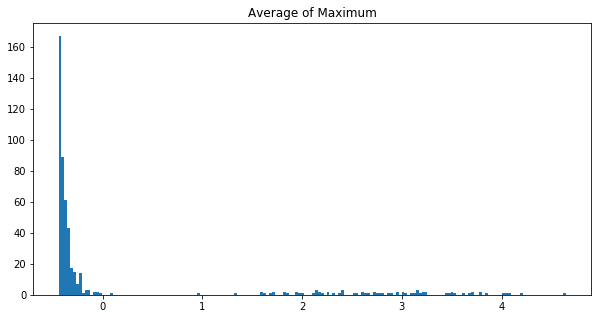

In [70]:
y_by_aom = aom(test_scores_norm, n_buckets=5)

plt.figure(figsize=[10,5])
plt.hist(y_by_aom, bins='auto')  # arguments are passed to np.histogram
plt.title("Average of Maximum")
plt.show()

In [71]:
df_test = pd.DataFrame(X_test)
df_test['y_by_aom_score'] = y_by_aom
df_test['y_by_aom_cluster'] = np.where(df_test['y_by_aom_score']<0, 0, 1)
df_test['y_by_aom_cluster'].value_counts()


0    425
1     75
Name: y_by_aom_cluster, dtype: int64

In [72]:
df_test.groupby('y_by_aom_cluster').mean()

,0,1,y_by_aom_score
y_by_aom_cluster,,,
0,8.965824,8.981820,-0.376359
1,-0.465629,-0.340412,2.716015


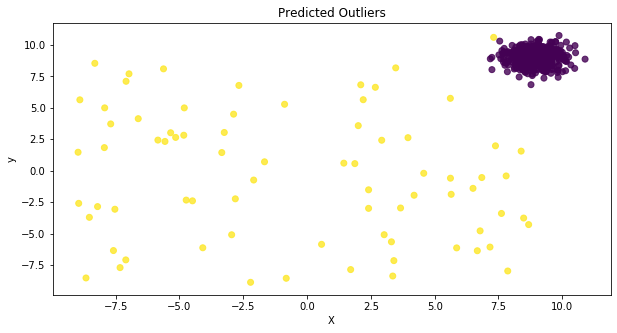

In [73]:
df_test.rename(columns={0:'Feature 0', 1:'Feature 1'}, inplace = True)
plt.figure(figsize=[10,5])
plt.scatter(df_test['Feature 0'], df_test['Feature 1'], c=df_test['y_by_aom_cluster'], alpha=0.8)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Predicted Outliers')
plt.show()

75 Outliers identified here, closer to our first method, but we can see one yello outlier in a simialr position to the purle cluster

Now let's try method 4 - the Maximum of Average.

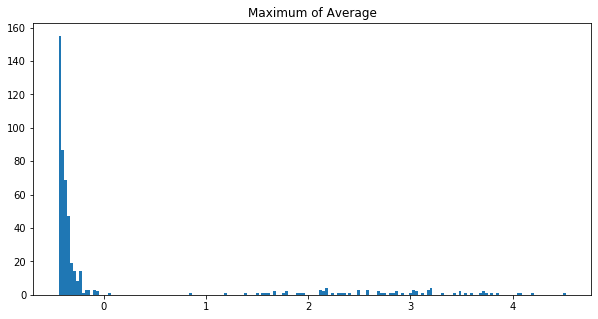

In [79]:
y_by_moa = moa(test_scores_norm, n_buckets=5)

plt.figure(figsize=[10,5])
plt.hist(y_by_moa, bins='auto')  # arguments are passed to np.histogram
plt.title("Maximum of Average")
plt.show()

In [80]:
df_test = pd.DataFrame(X_test)
df_test['y_by_moa_score'] = y_by_moa
df_test['y_by_moa_cluster'] = np.where(df_test['y_by_moa_score']<0, 0, 1)
df_test['y_by_moa_cluster'].value_counts()

0    425
1     75
Name: y_by_moa_cluster, dtype: int64

In [81]:
df_test.groupby('y_by_moa_cluster').mean()

,0,1,y_by_moa_score
y_by_moa_cluster,,,
0,8.965824,8.981820,-0.379227
1,-0.465629,-0.340412,2.657625


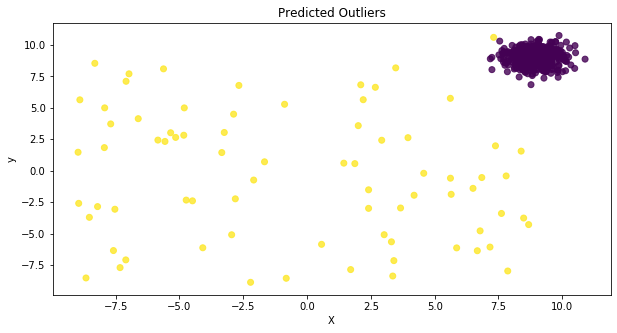

In [84]:
df_test.rename(columns={0:'Feature 0', 1:'Feature 1'}, inplace = True)
plt.figure(figsize=[10,5])
plt.scatter(df_test['Feature 0'], df_test['Feature 1'], c=df_test['y_by_moa_cluster'], alpha=0.8)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Predicted Outliers')
plt.show()